## Initialize

In [2]:
import pickle, os, sys

import numpy as np
import random
from pathlib import Path
from deap import creator, gp, base, tools
import librosa

import yaml

import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
plt.ion()

from ipywidgets import interactive, interact
import ipywidgets as widgets
import IPython.display as ip_disp
from  IPython.display import HTML

from supriya import SynthDefBuilder, CalculationRate
from supriya.ugens import Out, K2A
import numbers

import soundfile as sf

# Necessary to be able to import code from the main Python files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from gensynth.supercollider.representation import get_primitive_set
from gensynth.supercollider.synthesis import initialize_synthesis_dirs, synthesize_sounds

initialize_synthesis_dirs()

import nest_asyncio
nest_asyncio.apply()

# Fix for DEAP storing ephemeral stuff globally and complaining about redefining them.
gp_global_variables = gp.__dict__
if "frequency" in gp_global_variables:
    del gp_global_variables["frequency"]
if "multiplier" in gp_global_variables:
    del gp_global_variables["multiplier"]

# Define the classes necessary for de-pickling
primitive_set = get_primitive_set()

## Load data

In [3]:
config_directory = '../configs/'
config_directories = sorted(os.listdir(config_directory))
experiment_widget = widgets.Select(
    options=config_directories,
    value=None,
    description='Experiment',
    disabled=False,
    rows=len(config_directories)
)

display(experiment_widget)

Select(description='Experiment', options=('01_batch', '02_batch', '03_batch', '04_batch', '05_batch', '06_batc…

In [4]:
export_directory = '../results/'
log_directory = '../logs/pickle/merge_experiment/'
k = 20

In [5]:
experiment = experiment_widget.value
experiment_folder = config_directory + experiment
configurations = [config_file.rsplit('.')[0] for config_file in os.listdir(experiment_folder)]

config_widget = widgets.SelectMultiple(
    options=configurations,
    value=configurations,
    description='Configs',
    disabled=False,
    rows=len(configurations)
)

display(config_widget)

SelectMultiple(description='Configs', index=(0, 1, 2, 3, 4, 5, 6), options=('merge_with_one_point', 'base_moo'…

In [6]:
def load_dataframe(config_names):    
    populations = []

    for config_name in config_names:

        for trial_index in range(k):
            trial_directory = f'{log_directory}{config_name}/{trial_index:02d}/'

            if not os.path.exists(trial_directory):
                print(f"Warning: Missing path: {trial_directory}")
                continue
            
            with open(trial_directory + "config.yaml", "r") as file:
                config = yaml.safe_load(file)

            features = config['evolutionary_algorithm']['fitness_function']['feature']
            fitness_count = len(features)
            
            # Redefine classes for pickling with appropriate number of objectives
            creator.create("FitnessMin", base.Fitness, weights=[-1.0] * fitness_count)
            creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=primitive_set)
            
             # Iterate through all files in the directory and load the individual populations
            for f in os.listdir(os.fsencode(trial_directory)):
                file_name = os.fsdecode(f)
                
                if not file_name.endswith('.pkl'):
                    continue
                generation_index = int(file_name.rsplit('.')[0], base=10)
                file = open(trial_directory + file_name, 'rb')
                population = pickle.load(file)
                file.close()
                
                new_stats = []
                for index, individual in enumerate(population):
                    individual_stats = {}
                    individual_stats['config'] = config_name
                    individual_stats['trial'] = trial_index
                    individual_stats['generation'] = generation_index
                    individual_stats['individual'] = index
        
                    for fitness_index, fitness in enumerate(individual.fitness.values):
                        individual_stats[features[fitness_index]] = float(fitness)
                    
                    individual_stats['depth'] = individual.height
                    individual_stats['valid'] = not np.isinf(individual.fitness.values[0])
                    
                    individual_stats['expression'] = str(individual)
                    
                    new_stats.append(individual_stats)
            
                populations.extend(new_stats)
        
    df = pd.DataFrame(populations)
    return df

In [7]:
df = load_dataframe(config_widget.value)

/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [8]:
df.head()

config  trial  generation  individual        mel_db  \
0  merge_with_one_point      0         155           0   6629.148926   
1  merge_with_one_point      0         155           1  13891.015625   
2  merge_with_one_point      0         155           2  15508.177734   
3  merge_with_one_point      0         155           3  12068.358398   
4  merge_with_one_point      0         155           4  10299.498047   

          mfcc  zero_crossings  depth  valid  \
0  4904.527344        0.928571      2   True   
1  7414.945312        0.285714      2   True   
2  5077.154297        0.385714      1   True   
3  6290.706543        1.000000      0   True   
4  5141.806152        1.285714      0   True   

                                          expression  
0  BRFAR(SinOscAR(274.0, BrownNoiseKR()), 7280.0,...  
1  mul(SinOscAR(274.0, WhiteNoiseKR()), SinOscAR(...  
2             BRFKR(WhiteNoiseKR(), 15034.0, 2388.0)  
3                                     WhiteNoiseKR()  
4                                     BrownNoiseKR()

In [9]:
os.makedirs(os.path.abspath(export_directory + experiment_widget.value), exist_ok=True)

## SOO Bloat

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)
    names.append(name)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    separate_dfs.append(runs_df)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])

In [ ]:
os.makedirs(os.path.dirname(export_directory + experiment_widget.value), exist_ok=True)

In [ ]:
order = ['soo_no_bloat_control', 'soo_double_tournament', 'soo_layer_weighted', 'soo_both']

In [ ]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=order)
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

In [ ]:
sns.boxplot(data=min_df.reset_index(), x='fitness_0', y='config', order=order)
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_0')
plt.show()

## MOO Bloat

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)
    names.append(name)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    separate_dfs.append(runs_df)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])

In [ ]:
order = ['moo_no_bloat_control', 'moo_just_layer_weighted', 'moo_just_depth_objective', 'moo_layer_and_depth']

In [ ]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=order)
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

In [ ]:
sns.boxplot(data=min_df.reset_index(), x='fitness_0', y='config', order=order)
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_0')
plt.show()

In [ ]:
sns.boxplot(data=min_df.reset_index(), x='fitness_1', y='config', order=order)
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_1')
plt.show()

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)
    names.append(name)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    separate_dfs.append(runs_df)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])

In [ ]:
order = ['moo_no_bloat_control', 'moo_just_layer_weighted', 'moo_just_depth_objective', 'moo_layer_and_depth']

In [ ]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=order)
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

## Multiobjectivization

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = [] 

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    separate_dfs.append(runs_df)
    names.append(name)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
min_df = min_df.reset_index()

In [ ]:
sns.boxplot(data=min_df, x='mel_db', y='config', order=['soo_base', 'moo_mel_mfcc', 'moo_mel_zc', 'moo_mel_mfcc_zc'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mel')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='mfcc', y='config', order=['moo_mel_mfcc', 'moo_mfcc_zc', 'moo_mel_mfcc_zc'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mfcc')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='zero_crossings', y='config', order=['moo_mel_zc', 'moo_mfcc_zc', 'moo_mel_mfcc_zc'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mfcc')
plt.show()

## Merge Operator

In [10]:
df = df.loc[df.valid]
separate_dfs = []
names = [] 

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    separate_dfs.append(runs_df)
    names.append(name)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
min_df = min_df.reset_index()

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
mean_df = mean_df.reset_index()

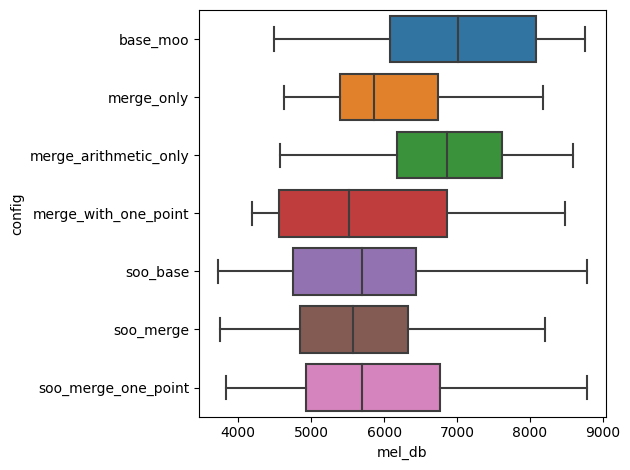

In [15]:
sns.boxplot(data=min_df, x='mel_db', y='config', order=['base_moo', 'merge_only', 'merge_arithmetic_only', 'merge_with_one_point', 'soo_base', 'soo_merge', 'soo_merge_one_point', ])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mel')
plt.show()

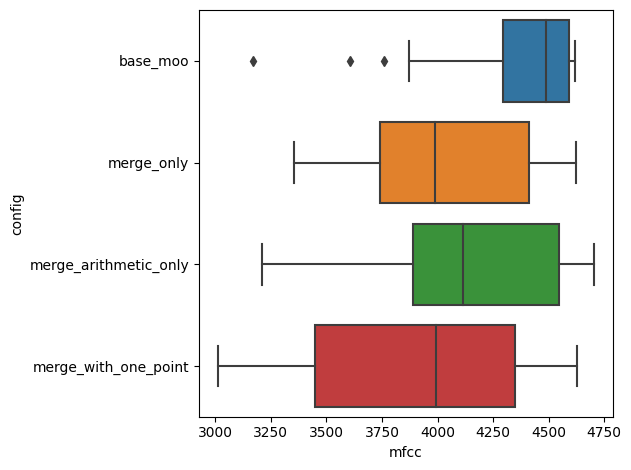

In [12]:
sns.boxplot(data=min_df, x='mfcc', y='config', order=['base_moo', 'merge_only', 'merge_arithmetic_only', 'merge_with_one_point'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mfcc')
plt.show()

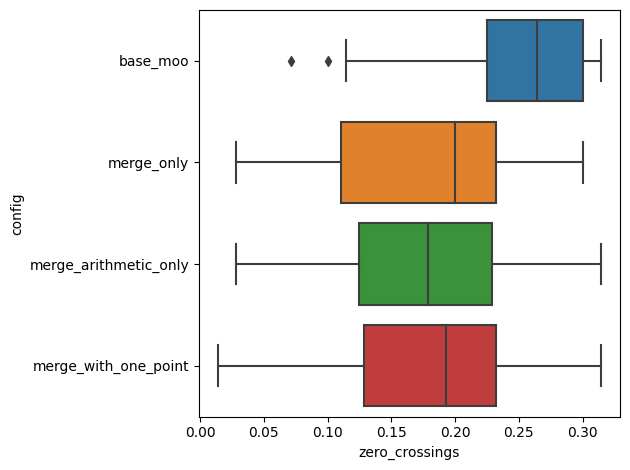

In [13]:
sns.boxplot(data=min_df, x='zero_crossings', y='config', order=['base_moo', 'merge_only', 'merge_arithmetic_only', 'merge_with_one_point'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_zc')
plt.show()

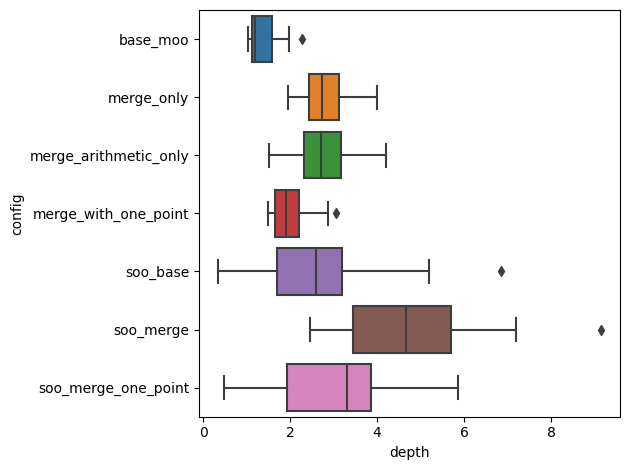

In [14]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=['base_moo', 'merge_only', 'merge_arithmetic_only', 'merge_with_one_point', 'soo_base', 'soo_merge', 'soo_merge_one_point'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

## Memetics

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = [] 

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    separate_dfs.append(runs_df)
    names.append(name)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
min_df = min_df.reset_index()

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
mean_df = mean_df.reset_index()

In [ ]:
sns.boxplot(data=min_df, x='mel_db', y='config', order=['base_soo', 'memetic_5_parameters'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mel')
plt.show()

In [ ]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=['base_soo', 'memetic_5_parameters'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

## Finale Percussion

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = [] 

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    print(f"{name} best trial by mel_db: {runs_df['mel_db'].idxmin()}")
    print(f"{name} best trial by mfcc: {runs_df['mfcc'].idxmin()}")
    print(f"{name} best trial by zc: {runs_df['zero_crossings'].idxmin()}")
    separate_dfs.append(runs_df)
    names.append(name)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
min_df = min_df.reset_index()

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
mean_df = mean_df.reset_index()

In [ ]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=['snap', 'mouth_pop', 'wood', 'snare_drum', 'container', 'metal',])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='mel_db', y='config', order=['snap', 'mouth_pop', 'wood', 'snare_drum', 'container', 'metal',])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mel')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='mfcc', y='config', order=['snap', 'mouth_pop', 'wood', 'snare_drum', 'container', 'metal',])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mfcc')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='zero_crossings', y='config', order=['snap', 'mouth_pop', 'wood', 'snare_drum', 'container', 'metal',])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_zero_crossings')
plt.show()

## Finale Tones & Organic

In [ ]:
df = df.loc[df.valid]
separate_dfs = []
names = [] 

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").min(numeric_only=True)
    print(f"{name} best trial by mel_db: {runs_df['mel_db'].idxmin()}")
    print(f"{name} best trial by mfcc: {runs_df['mfcc'].idxmin()}")
    print(f"{name} best trial by zc: {runs_df['zero_crossings'].idxmin()}")
    separate_dfs.append(runs_df)
    names.append(name)

min_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
min_df = min_df.reset_index()

separate_dfs = []
for name, group in df.groupby("config"):
    runs_df = group.groupby("trial").depth.mean()
    separate_dfs.append(runs_df)

mean_df = pd.concat(separate_dfs, keys=names, names=['config', 'trial'])
mean_df = mean_df.reset_index()

In [ ]:
sns.boxplot(data=mean_df.reset_index(), x='depth', y='config', order=['triangle', 'kalimba', 'rooster'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/depths')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='mel_db', y='config', order=['triangle', 'kalimba', 'rooster'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mel')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='mfcc', y='config', order=['triangle', 'kalimba', 'rooster'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_mfcc')
plt.show()

In [ ]:
sns.boxplot(data=min_df, x='zero_crossings', y='config', order=['triangle', 'kalimba', 'rooster'])
plt.tight_layout()
plt.savefig(export_directory + experiment_widget.value + '/fitness_zero_crossings')
plt.show()